<a href="https://colab.research.google.com/github/victorialovefranklin/CyberInfrastructure-Data-Analysis-for-COVID-19-Surveillance/blob/main/Lab_3_Data_Preprocessing_%26_Outlier_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 3: Data Preprocessing & Outlier Detection**
**Deliverable:** Cleaned CSV(s), reproducible code (handle missing values, data types, outliers, standardization).

**Datasets:**
- CDC_COVIDNET_ClinicalCases_2024_2025.csv`
- CDC_NWSS_TN_Wastewater.csv`
- WastewaterSCAN_TN_SARS2.csv.csv`

Install Packages

In [ ]:
!pip -q install scikit-learn

# **Code Explaination:**

This code snippet installs the scikit-learn library using pip. The ! at the beginning indicates that this is a shell command. The -q flag makes the installation quiet, meaning it will not display the progress or output messages unless there is an error.

Scikit-learn is a popular machine learning library in Python that provides tools for various tasks, including classification, regression, clustering, and dimensionality reduction.



# **1) Setup**

In [ ]:
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Colab detected. Drive mounted.")
else:
    print("Running outside Colab.")

import pandas as pd
import numpy as np
from pathlib import Path


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Colab detected. Drive mounted.


# **Code Explaination:**

This code mounts Google Drive to Google Colab and imports necessary libraries for data manipulation and file path handling.

**try...except:**  This block attempts to import the google.colab library. If successful, it sets IN_COLAB to True, indicating the code is running in Colab. Otherwise, IN_COLAB is set to False.

**if IN_COLAB:** If running in Colab, this block mounts Google Drive to the /content/drive directory, allowing access to files stored in Drive.

**import pandas as pd:** Imports the pandas library, used for data manipulation and analysis.

**import numpy as np:** Imports the NumPy library, used for numerical operations.

**from pathlib import Path:** Imports the Path object from the pathlib module, which provides an object-oriented way to handle file paths.

## **2) Configure File Paths**





In [ ]:
COVID_PATH = Path("Raw Data/CDC_COVIDNET_ClinicalCases_2024_2025.csv")
NWSS_PATH  = Path("Raw Data/CDC_NWSS_TN_Wastewater.csv")
WSCAN_PATH = Path("Raw Data/WastewaterSCAN_TN_SARS2.csv")

OUT_DIR = Path("/content/drive/MyDrive/Secure_Biosurveillance_Data")
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Output dir:", OUT_DIR)

Output dir: /content/drive/MyDrive/Secure_Biosurveillance_Data


# **3) Helper Functions (Standardize, Missing, Types, Outliers)**

In [ ]:
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
                  .str.lower()
                  .str.replace(" ", "_")
                  .str.replace(r"[()/%]", "", regex=True)
                  .str.replace(r"[\\/]", "", regex=True)
    )
    return df

def drop_high_missing(df: pd.DataFrame, threshold: float = 0.4) -> pd.DataFrame:
    share = df.isna().mean()
    to_drop = list(share[share > threshold].index)
    if to_drop:
        df = df.drop(columns=to_drop)
    return df

def impute_values(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna("Unknown")
    return df

def coerce_dates(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    date_like = [c for c in df.columns if "date" in c or c.endswith("_dt")]
    for c in date_like:
        df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

def coerce_numerics(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == object:
            converted = pd.to_numeric(df[c].astype(str).str.replace(",", ""), errors="coerce")
            if converted.notna().mean() >= 0.5:
                df[c] = converted
    return df

def remove_outliers_z(df: pd.DataFrame, z_thresh: float = 3.0) -> pd.DataFrame:
    df = df.copy()
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        series = df[col]
        if series.std(ddof=0) == 0 or series.isna().all():
            continue
        z = (series - series.mean()) / series.std(ddof=0)
        df = df[(z.abs() < z_thresh) | series.isna()]
    return df

def summarize_missing(df: pd.DataFrame, name: str):
    miss = df.isna().mean().sort_values(ascending=False)
    print(f"Top missing columns for {name}:\n", miss.head(10))


## **4) Load Data**

In [ ]:
covid = pd.read_csv("/content/drive/MyDrive/Secure_Biosurveillance_Data/Raw Data/CDC_COVIDNET_ClinicalCases.csv")
nwss  = pd.read_csv("/content/drive/MyDrive/Secure_Biosurveillance_Data/Raw Data/CDC_NWSS_TN_Wastewater.csv")
wscan = pd.read_csv("/content/drive/MyDrive/Secure_Biosurveillance_Data/Raw Data/WastewaterSCAN_TN_SARS2.csv")

print("Shapes -> COVID:", covid.shape, "| NWSS:", nwss.shape, "| WSCAN:", wscan.shape)

Shapes -> COVID: (12760, 9) | NWSS: (280, 9) | WSCAN: (2, 69)


## **5) Standardize Column Names**

In [ ]:
covid = clean_columns(covid)
nwss  = clean_columns(nwss)
wscan = clean_columns(wscan)

print("Sample COVID cols:", list(covid.columns)[:10])
print("Sample NWSS cols:", list(nwss.columns)[:10])
print("Sample WSCAN cols:", list(wscan.columns)[:10])


Sample COVID cols: ['state', 'season', '_weekenddate', 'agecategory_legend', 'sex_label', 'race_label', 'type', 'weeklyrate', 'cumulativerate']
Sample NWSS cols: ['stateterritory', 'week_ending_date', 'data_collection_period', 'stateterritory_wval', 'national_wval', 'regional_wval', 'wval_category', 'coverage', 'date_updated']
Sample WSCAN cols: ['state', 'us_census_region', 'plant', 'site_name', 'last_sample_date', 'ba.2_lppa24s_category', 'ba.2_lppa24s_method', 'ba.4_orf1a_del_141-143_category', 'ba.4_orf1a_del_141-143_method', 'c_auris_category']


## **6) Inspect & Handle Missing Values**

In [ ]:
summarize_missing(covid, "COVID")
summarize_missing(nwss, "NWSS")
summarize_missing(wscan, "WSCAN")

covid = drop_high_missing(covid, threshold=0.4)
nwss  = drop_high_missing(nwss,  threshold=0.4)
wscan = drop_high_missing(wscan, threshold=0.4)

covid = impute_values(covid)
nwss  = impute_values(nwss)
wscan = impute_values(wscan)


Top missing columns for COVID:
 state                 0.0
season                0.0
_weekenddate          0.0
agecategory_legend    0.0
sex_label             0.0
race_label            0.0
type                  0.0
weeklyrate            0.0
cumulativerate        0.0
dtype: float64
Top missing columns for NWSS:
 coverage                  0.910714
stateterritory_wval       0.032143
stateterritory            0.000000
data_collection_period    0.000000
week_ending_date          0.000000
national_wval             0.000000
regional_wval             0.000000
wval_category             0.000000
date_updated              0.000000
dtype: float64
Top missing columns for WSCAN:
 evd68_trend          1.0
influenza_a_level    1.0
influenza_a_trend    1.0
evd68_level          1.0
noro_g2_trend        0.5
rota_trend           0.5
rota_level           0.5
noro_g2_level        0.5
n_gene_trend         0.5
n_gene_level         0.5
dtype: float64


# **Outlier Detection & Visualization Across Biosurveillance Datasets**

This notebook analyzes three datasets — **COVID Clinical Cases**, **NWSS Wastewater**, and **WastewaterSCAN SARS-CoV-2** — to identify unusual observations, compare outlier detection methods, and visualize time series with outliers highlighted.

## Methods Used
- **Z-Score** (statistical distance): flags points with \(|z| \ge 3\) by default. Good for roughly normal distributions.
- **IQR Rule** (robust spread): flags values outside \([Q1 - k·IQR,\; Q3 + k·IQR]\).
  - **k (IQR threshold)**: the *tuning knob* for strictness.  
    - Typical: `k = 1.5` (strict; can over-flag in skewed/seasonal data)  
    - Relaxed: `k = 3.0` (recommended for epidemiological series with bursts)
- **Isolation Forest** (multivariate anomaly detection): unsupervised model isolating rare points; `contamination` sets expected anomaly share (e.g., 0.02 ≈ 2%).

## Goals
1) Detect extreme or unusual points while preserving true epidemiological signals.  
2) Compare methods (Z, IQR, ISO) and their overlaps to judge consistency.  
3) Produce *clean* outlier summaries and *clear visuals* (counts, percentages, and time series with red outliers).

**Outputs you’ll get:**
- A **summary table** and **overlap table** across methods.  
- **Bar charts** (counts & percents) per dataset.  
- **Time-series plots** (overall & per-site) with outliers highlighted in **red**.  
- CSV exports of summaries in your Drive.



=== Outlier Method Summary ===


,Dataset,Rows in outlier file,Z-score outliers,IQR outliers,IsolationForest outliers,Any outlier (combined),Z-score %,IQR %,IsolationForest %,Any %
0,COVID Clinical Cases,2309,463,2309,256,2309,20.051971,100.0,11.087051,100.0
1,NWSS Wastewater,14,7,14,6,14,50.000000,100.0,42.857143,100.0
2,WastewaterSCAN SARS2,0,0,0,0,0,0.000000,0.0,0.000000,0.0



=== Method Overlaps (counts) ===


,Dataset,Z ∩ IQR,Z ∩ ISO,IQR ∩ ISO,Z ∩ IQR ∩ ISO
0,COVID Clinical Cases,463,256,256,256
1,NWSS Wastewater,7,5,6,5
2,WastewaterSCAN SARS2,0,0,0,0


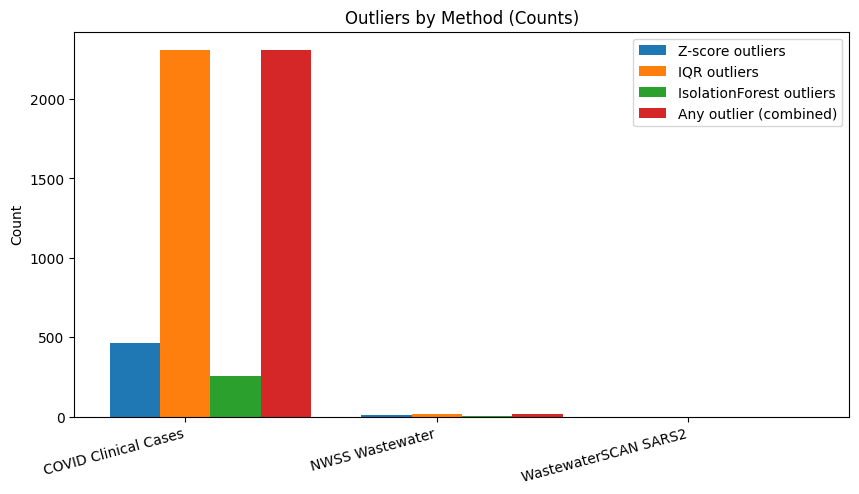

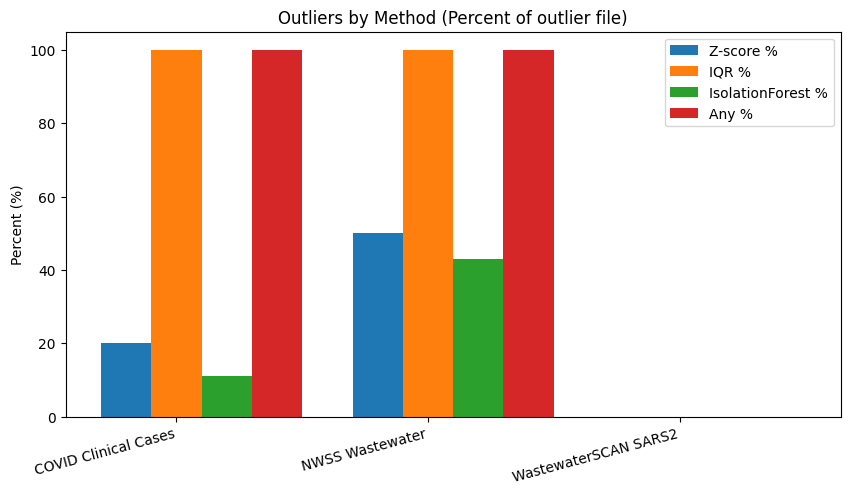


=== COVID ===
Date column:  _weekenddate
Value column: weeklyrate
Site column:  state


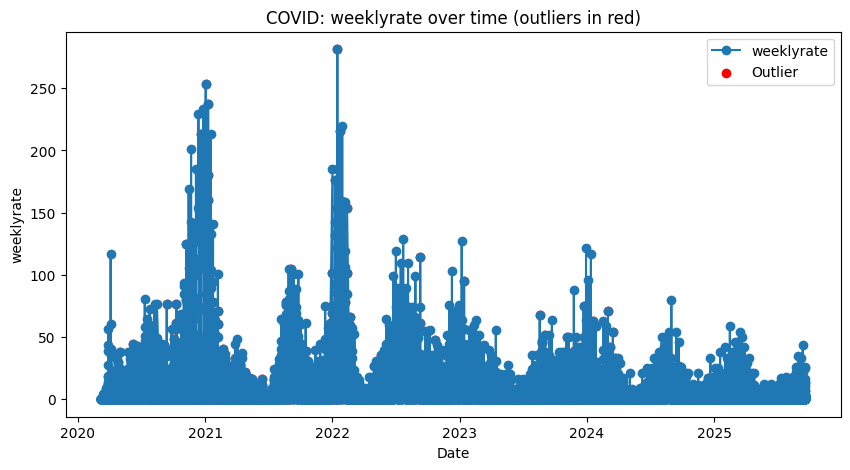

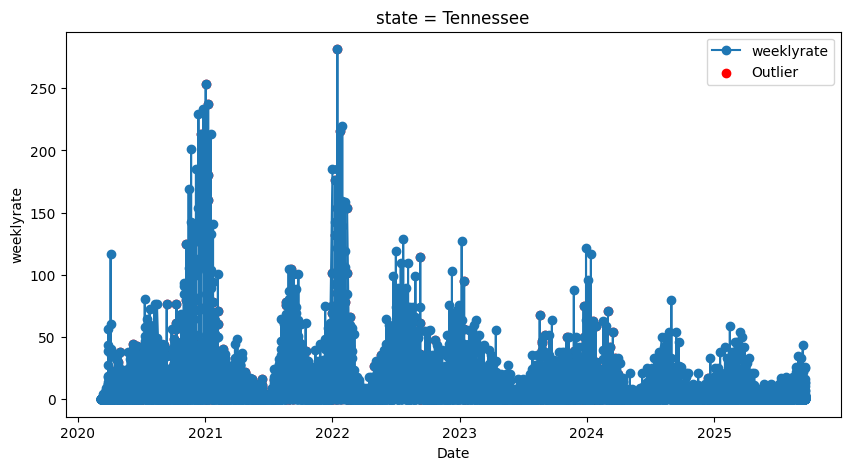

ℹ️ Using first numeric column for nwss: stateterritory_wval

=== NWSS ===
Date column:  week_ending_date
Value column: stateterritory_wval


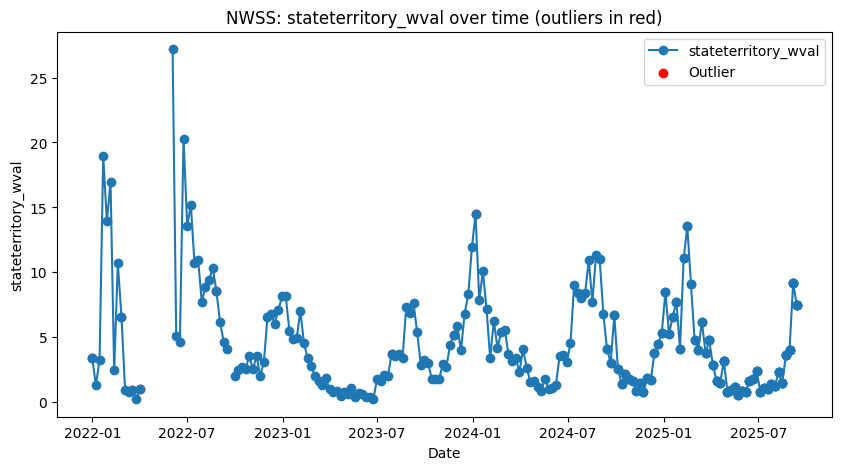

ℹ️ Using first numeric column for wscan: evd68_level

=== WSCAN ===
Date column:  last_sample_date
Value column: evd68_level


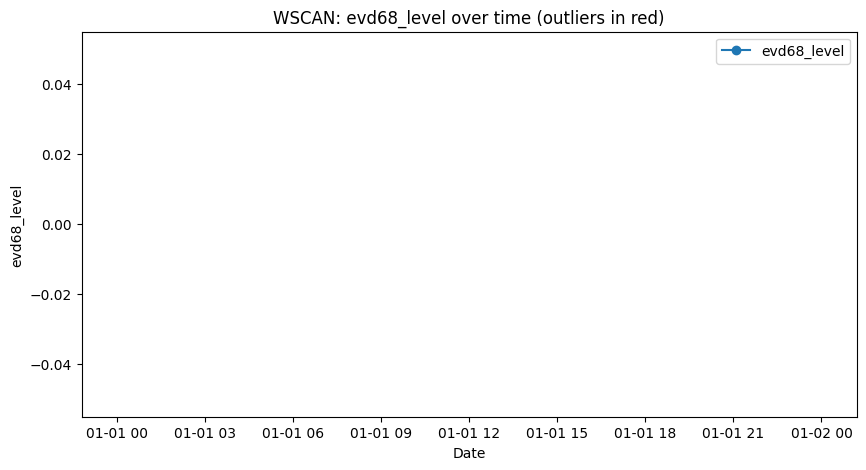

In [ ]:
# =========================================================
# 0) Setup (Colab): mount Drive if needed
# =========================================================
# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (10, 5)

# =========================================================
# 1) File Locations
#    - Update BASE_DIR if your Drive folder is different
# =========================================================
BASE_DIR   = Path("/content/drive/MyDrive/Secure_Biosurveillance_Data")
OUTLIER_DIR = BASE_DIR / "Outlier Data"   # where *_outliers_combined.csv live
SUMMARY_DIR = BASE_DIR / "Outlier Data"   # summaries saved here
SUMMARY_DIR.mkdir(parents=True, exist_ok=True)

OUTLIER_FILES = {
    "COVID Clinical Cases": OUTLIER_DIR / "CDC_COVIDNET_ClinicalCases_outliers_combined.csv",
    "NWSS Wastewater":      OUTLIER_DIR / "CDC_NWSS_TN_Wastewater_outliers_combined.csv",
    "WastewaterSCAN SARS2": OUTLIER_DIR / "WastewaterSCAN_TN_SARS2_outliers_combined.csv",
}

# Also read RAW data (for time series plotting of values)
RAW = {
    "covid": BASE_DIR / "Raw Data/CDC_COVIDNET_ClinicalCases.csv",
    "nwss":  BASE_DIR / "Raw Data/CDC_NWSS_TN_Wastewater.csv",
    "wscan": BASE_DIR / "Raw Data/WastewaterSCAN_TN_SARS2.csv",
}

# Matching masks saved earlier (True/False per row, same row order as RAW)
MASKS = {
    "covid": OUTLIER_DIR / "CDC_COVIDNET_ClinicalCases_combined_outlier_mask.csv",
    "nwss":  OUTLIER_DIR / "CDC_NWSS_TN_Wastewater_combined_outlier_mask.csv",
    "wscan": OUTLIER_DIR / "WastewaterSCAN_TN_SARS2_combined_outlier_mask.csv",
}

# =========================================================
# 2) Helpers (reading, counting, cleaning, visuals)
# =========================================================
def safe_bool_sum(df, col):
    if col in df.columns:
        return df[col].astype(bool).sum()
    return np.nan

def read_outliers(path: Path) -> pd.DataFrame:
    """Read an outlier file and normalize expected columns to bool."""
    if not path.exists():
        return pd.DataFrame(columns=["z_outlier", "iqr_outlier", "iso_outlier", "any_outlier"])
    df = pd.read_csv(path)
    for c in ["z_outlier", "iqr_outlier", "iso_outlier", "any_outlier"]:
        if c not in df.columns:
            df[c] = False
        df[c] = df[c].astype(bool)
    return df

def bar_chart(df, title, value_cols, ylabel):
    plt.figure()
    x = np.arange(len(df))
    width = 0.2
    for i, col in enumerate(value_cols):
        vals = df[col].fillna(0)
        plt.bar(x + i*width, vals, width, label=col)
    plt.xticks(x + width, df["Dataset"], rotation=15, ha="right")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (df.columns.str.strip()
                             .str.lower()
                             .str.replace(" ", "_")
                             .str.replace(r"[()/%]", "", regex=True)
                             .str.replace(r"[\\/]", "", regex=True))
    return df

def pick_first(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def plot_time_series_with_outliers(df: pd.DataFrame, date_col: str, value_col: str, outlier_mask: pd.Series, title: str):
    """Plot a time series with outliers (True in outlier_mask) in red."""
    dfx = df[[date_col, value_col]].copy()
    dfx[date_col] = pd.to_datetime(dfx[date_col], errors="coerce")
    dfx = dfx.sort_values(date_col).reset_index(drop=True)

    # Align mask to sorted frame
    if len(outlier_mask) == len(df):
        mask_sorted = outlier_mask.reindex(df.index).reset_index(drop=True)
    else:
        # fallback: assume same ordering already
        mask_sorted = outlier_mask.reset_index(drop=True)
    mask_sorted = mask_sorted.astype(bool)

    plt.figure()
    plt.plot(dfx[date_col], dfx[value_col], marker="o", linestyle="-", label=value_col)
    out = dfx[mask_sorted]
    if not out.empty:
        plt.scatter(out[date_col], out[value_col], color="red", label="Outlier")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(value_col)
    plt.legend()
    plt.show()

def plot_per_site(df: pd.DataFrame, date_col: str, value_col: str, site_col: str, outlier_mask: pd.Series, max_sites=6):
    """Small multiples by top sites (by row count)."""
    top_sites = df[site_col].value_counts().head(max_sites).index.tolist()
    for s in top_sites:
        g = df[df[site_col] == s].copy()
        g[date_col] = pd.to_datetime(g[date_col], errors="coerce")
        g = g.sort_values(date_col).reset_index(drop=True)

        if len(outlier_mask) == len(df):
            mask_g = outlier_mask[df[site_col] == s].reset_index(drop=True)
        else:
            mask_g = pd.Series(False, index=g.index)

        plt.figure()
        plt.plot(g[date_col], g[value_col], marker="o", linestyle="-", label=value_col)
        go = g[mask_g]
        if not go.empty:
            plt.scatter(go[date_col], go[value_col], color="red", label="Outlier")
        plt.title(f"{site_col} = {s}")
        plt.xlabel("Date")
        plt.ylabel(value_col)
        plt.legend()
        plt.show()

# =========================================================
# 3) Build Outlier Method Summary + Overlaps (from *_outliers_combined.csv)
# =========================================================
rows = []
overlap_rows = []

for name, path in OUTLIER_FILES.items():
    df = read_outliers(path)
    n = len(df)

    zc   = safe_bool_sum(df, "z_outlier")
    iqrc = safe_bool_sum(df, "iqr_outlier")
    isoc = safe_bool_sum(df, "iso_outlier")
    anyc = safe_bool_sum(df, "any_outlier")

    both_z_iqr   = (df["z_outlier"] & df["iqr_outlier"]).sum() if n else 0
    both_z_iso   = (df["z_outlier"] & df["iso_outlier"]).sum() if n else 0
    both_iqr_iso = (df["iqr_outlier"] & df["iso_outlier"]).sum() if n else 0
    all_three    = (df["z_outlier"] & df["iqr_outlier"] & df["iso_outlier"]).sum() if n else 0

    rows.append({
        "Dataset": name,
        "Rows in outlier file": n,
        "Z-score outliers": zc,
        "IQR outliers": iqrc,
        "IsolationForest outliers": isoc,
        "Any outlier (combined)": anyc,
        "Z-score %": (zc/n*100 if n else 0),
        "IQR %": (iqrc/n*100 if n else 0),
        "IsolationForest %": (isoc/n*100 if n else 0),
        "Any %": (anyc/n*100 if n else 0),
    })

    overlap_rows.append({
        "Dataset": name,
        "Z ∩ IQR": both_z_iqr,
        "Z ∩ ISO": both_z_iso,
        "IQR ∩ ISO": both_iqr_iso,
        "Z ∩ IQR ∩ ISO": all_three
    })

summary_df  = pd.DataFrame(rows)
overlaps_df = pd.DataFrame(overlap_rows)

print("=== Outlier Method Summary ===")
display(summary_df)
print("\n=== Method Overlaps (counts) ===")
display(overlaps_df)

# Save summaries
summary_df.to_csv(SUMMARY_DIR / "outlier_method_summary.csv", index=False)
overlaps_df.to_csv(SUMMARY_DIR / "outlier_method_overlaps.csv", index=False)

# Bar charts
bar_chart(
    summary_df,
    title="Outliers by Method (Counts)",
    value_cols=["Z-score outliers", "IQR outliers", "IsolationForest outliers", "Any outlier (combined)"],
    ylabel="Count"
)
bar_chart(
    summary_df,
    title="Outliers by Method (Percent of outlier file)",
    value_cols=["Z-score %", "IQR %", "IsolationForest %", "Any %"],
    ylabel="Percent (%)"
)

# =========================================================
# 4) Time-Series Visuals with Outliers Highlighted (overall + per site)
#    - Adjust candidate column names below if your schema differs
# =========================================================
CONFIG = {
    "covid": {
        "date_col_candidates": ["_weekenddate", "weekend_date", "week_end_date"],
        "value_col_candidates": ["weeklyrate", "cumulativerate"],
        "site_col_candidates":  ["state", "location", "jurisdiction"]
    },
    "nwss": {
        "date_col_candidates": ["week_ending_date", "collection_week", "sample_date"],
        "value_col_candidates": ["state_territory_wval", "wval", "sars_cov_2_norm_value", "value", "conc"],
        "site_col_candidates":  ["site_id", "facility", "county", "state"]
    },
    "wscan": {
        "date_col_candidates": ["last_sample_date", "sample_date", "collection_date"],
        "value_col_candidates": ["sars_cov_2_copies", "gene_copies", "concentration", "value"],
        "site_col_candidates":  ["site_id", "site", "wwtp", "facility"]
    }
}

for key in ["covid", "nwss", "wscan"]:
    raw_p = Path(RAW[key]); mask_p = Path(MASKS[key])
    if not raw_p.exists():
        print(f"⚠️ Missing RAW file for {key}: {raw_p}"); continue
    if not mask_p.exists():
        print(f"⚠️ Missing MASK file for {key}: {mask_p}"); continue

    df_raw = clean_columns(pd.read_csv(raw_p))
    mask_df = pd.read_csv(mask_p)
    mask_col = pick_first(mask_df, ["any_outlier"]) or mask_df.columns[0]
    any_outlier = mask_df[mask_col].astype(bool)

    date_col = pick_first(df_raw, CONFIG[key]["date_col_candidates"]) or "date"
    value_col = pick_first(df_raw, CONFIG[key]["value_col_candidates"])
    site_col  = pick_first(df_raw, CONFIG[key]["site_col_candidates"])

    if date_col not in df_raw.columns:
        print(f"⚠️ No date column found for {key}. Checked: {CONFIG[key]['date_col_candidates']}"); continue
    if not value_col:
        # Fallback to first numeric
        num_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
        if not num_cols:
            print(f"⚠️ No numeric columns to plot for {key}."); continue
        value_col = num_cols[0]
        print(f"ℹ️ Using first numeric column for {key}: {value_col}")

    print(f"\n=== {key.upper()} ===")
    print(f"Date column:  {date_col}")
    print(f"Value column: {value_col}")
    if site_col: print(f"Site column:  {site_col}")

    plot_time_series_with_outliers(
        df=df_raw, date_col=date_col, value_col=value_col,
        outlier_mask=any_outlier,
        title=f"{key.upper()}: {value_col} over time (outliers in red)"
    )

    if site_col:
        plot_per_site(
            df=df_raw, date_col=date_col, value_col=value_col, site_col=site_col,
            outlier_mask=any_outlier, max_sites=6
        )


**bold text**## 8) Detect & Remove Outliers (Z-score)

## **10)Export Simple Data Dictionaries**

In [ ]:
# =========================================================
# 📑 Export Data Dictionaries for Cleaned Datasets
# =========================================================

import pandas as pd
from pathlib import Path

# --- Define output directory for data dictionaries ---
DD_DIR = Path("/content/drive/MyDrive/Secure_Biosurveillance_Data/Data Dictionary")
DD_DIR.mkdir(parents=True, exist_ok=True)

# --- Function to create data dictionary ---
def data_dictionary(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        "column": df.columns,
        "dtype": [str(df[c].dtype) for c in df.columns],
        "missing_pct": [round(df[c].isna().mean() * 100, 2) for c in df.columns]
    }).sort_values("column")

# --- Build data dictionaries ---
dic_covid = data_dictionary(covid_clean)
dic_nwss  = data_dictionary(nwss_clean)
dic_wscan = data_dictionary(wscan_clean)

# --- Save to CSVs ---
dic_covid.to_csv(DD_DIR / "dic_covid_cases.csv", index=False)
dic_nwss.to_csv(DD_DIR / "dic_nwss.csv", index=False)
dic_wscan.to_csv(DD_DIR / "dic_wscan.csv", index=False)

print("✅ Data dictionaries saved to:", DD_DIR)


✅ Data dictionaries saved to: /content/drive/MyDrive/Secure_Biosurveillance_Data/Data Dictionary
